In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression


df1 = pd.read_csv('HoC-GE2024-results-by-candidate.csv')
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4515 entries, 0 to 4514
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ONS ID                                 4515 non-null   object 
 1   ONS region ID                          4507 non-null   object 
 2   Constituency name                      4515 non-null   object 
 3   County name                            0 non-null      float64
 4   Region name                            4515 non-null   object 
 5   Country name                           4515 non-null   object 
 6   Constituency type                      4515 non-null   object 
 7   Party name                             4515 non-null   object 
 8   Party abbreviation                     4515 non-null   object 
 9   Electoral Commission party ID          4055 non-null   object 
 10  MNIS party ID                          4515 non-null   int64  
 11  Elec

In [2]:
df2 = pd.read_csv('HoC-GE2024-results-by-constituency.csv')

print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ONS ID                 650 non-null    object 
 1   ONS region ID          650 non-null    object 
 2   Constituency name      650 non-null    object 
 3   County name            0 non-null      float64
 4   Region name            650 non-null    object 
 5   Country name           650 non-null    object 
 6   Constituency type      650 non-null    object 
 7   Declaration time       0 non-null      float64
 8   Member first name      650 non-null    object 
 9   Member surname         650 non-null    object 
 10  Member gender          650 non-null    object 
 11  Result                 650 non-null    object 
 12  First party            650 non-null    object 
 13  Second party           650 non-null    object 
 14  Electorate             650 non-null    int64  
 15  Valid 

We get vote share in each constituency, and also we prepare colors for scatter plot visualization

In [3]:
shares_by_party = df2.copy()
list_of_party_columns = ['Con', 'Lab', 'LD', 'RUK', 'Green', 'SNP', 'PC', 'DUP', 'SF', 'SDLP', 'UUP', 'APNI', 'All other candidates', 'Of which other winner']
for party in list_of_party_columns:
    shares_by_party[party] = shares_by_party[party]/shares_by_party['Valid votes']

color = {'Lab': 'red', 'Con': 'blue', 'LD': 'orange', 'Green': 'green', 'RUK': 'cyan', 'SNP': 'yellow'}
def get_party_color(party):
    if party in color:
        return color[party]
    return 'gray'

My own implementation

In [4]:
def k_nearest_neighbours(k, train, test):
    most_common_results = []
    for test_value in test:
      results = []
      for train_value in train:
        results.append([train_value[0], np.sqrt((train_value[1] - test_value[1])**2+(train_value[2] - test_value[2])**2)])
      results.sort(key=lambda x: x[1])
      closest_entries = [r[0] for r in results[:k]]
      most_common_result = max(set(closest_entries), key=closest_entries.count)
      most_common_results.append(most_common_result)
    return most_common_results

Trying to predict the winner of the constituency using only two parties.
According to the system, a party wins if it's the biggest party in constituency. However, is it possble to predict election result by only using the votes that 'far-left' and 'far-right' have received?

<ipython-input-5-c03d08657c71>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  shares_winner = shares_by_party[['First party', *[first_party, second_party]]][~shares_by_party['Region name'].isin(['Scotland', 'Wales', 'Northern Ireland'])][~shares_by_party['First party'].isin(['Spk', 'Ind'])]


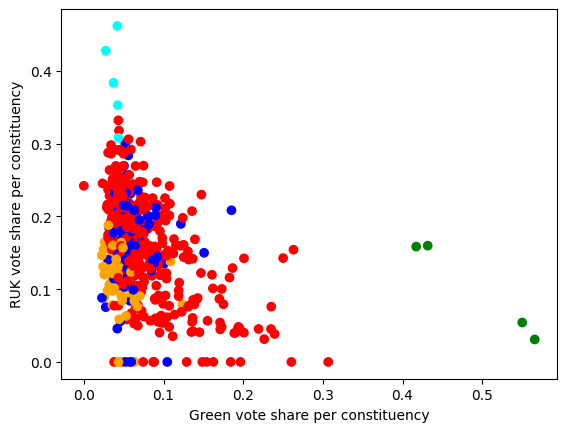

In [5]:
from sklearn.model_selection import train_test_split
first_party = 'Green'
second_party = 'RUK'

shares_winner = shares_by_party[['First party', *[first_party, second_party]]][~shares_by_party['Region name'].isin(['Scotland', 'Wales', 'Northern Ireland'])][~shares_by_party['First party'].isin(['Spk', 'Ind'])]
train_indexes, test_indexes = train_test_split(range(len(shares_winner)), random_state=100)
train, test = shares_winner.values[train_indexes], shares_winner.values[test_indexes]


x_line = shares_winner[first_party]
y_line = shares_winner[second_party]
color_array = [get_party_color(party) for party in shares_winner['First party']]

plt.scatter(x_line, y_line, color=color_array)
plt.xlabel(first_party + ' vote share per constituency')
plt.ylabel(second_party + ' vote share per constituency')
plt.show()

Preparing data splits for scikit

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_metrics(y_true, y_pred):
  print(f'Accuracy   : {accuracy_score(y_true, y_pred):.2f}')
  print(f'Precision  : {precision_score(y_true, y_pred, average="macro"):.2f}')
  print(f'Recall     : {recall_score(y_true, y_pred, average="macro"):.2f}')
  print(f'F1-score   : {f1_score(y_true, y_pred, average="macro"):.2f}')

Xs_train = train[:,[1,2]]
y_train = train[:,[0]].ravel()
Xs_test = test[:,[1,2]]
y_test = test[:,[0]].ravel()

Comparing library implementation to mine.
Results are slightly different, probably because the library handles tiebreaks differently - I take the first entry as prediction, while the library probably handles it a bit different

In [7]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
knn.fit(Xs_train, y_train)

print('Training set:')
print_metrics(y_train, knn.predict(Xs_train))
print()
print('Test set (library):')
print_metrics(y_test, knn.predict(Xs_test))
print('Test set (my implementation):')
print_metrics(y_test, k_nearest_neighbours(3, train, test))

Training set:
Accuracy   : 0.81
Precision  : 0.86
Recall     : 0.77
F1-score   : 0.80

Test set (library):
Accuracy   : 0.67
Precision  : 0.71
Recall     : 0.65
F1-score   : 0.67
Test set (my implementation):
Accuracy   : 0.67
Precision  : 0.71
Recall     : 0.65
F1-score   : 0.67


Logistic regression

If class weight is not used, then the model maximises the number for the labour party (which strongly outnumbers other entries), maximising accuracy. This one does a better job maximising precision

In [9]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty=None, class_weight="balanced") # class weight needed, because we need precision, not accuracy
lr.fit(Xs_train, y_train)

print('Training set:')
print_metrics(y_train, lr.predict(Xs_train))
print()
print('Test set:')
print_metrics(y_test, lr.predict(Xs_test))

Training set:
Accuracy   : 0.53
Precision  : 0.57
Recall     : 0.76
F1-score   : 0.60

Test set:
Accuracy   : 0.63
Precision  : 0.70
Recall     : 0.76
F1-score   : 0.71


Decision tree

In [10]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='entropy', max_depth=12)
# Now using non-scaled data:
dt.fit(Xs_train, y_train)

print('Training set:')
print_metrics(y_train, dt.predict(Xs_train))
print()
print('Test set:')
print_metrics(y_test, dt.predict(Xs_test))

Training set:
Accuracy   : 0.92
Precision  : 0.97
Recall     : 0.93
F1-score   : 0.95

Test set:
Accuracy   : 0.73
Precision  : 0.73
Recall     : 0.69
F1-score   : 0.70


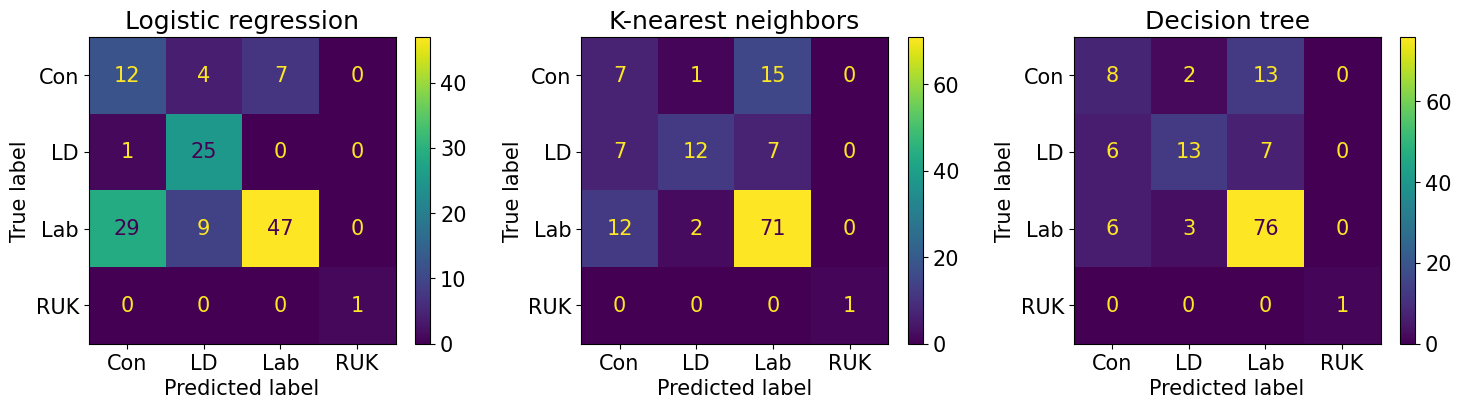

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrices
plt.rc('font', size=15)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
ConfusionMatrixDisplay.from_estimator(lr, Xs_test, y_test, ax=ax1)
ConfusionMatrixDisplay.from_estimator(knn, Xs_test, y_test, ax=ax2)
ConfusionMatrixDisplay.from_estimator(dt, Xs_test, y_test, ax=ax3)

ax1.set_title('Logistic regression')
ax2.set_title('K-nearest neighbors')
ax3.set_title('Decision tree')
plt.tight_layout()

Lets test if the model is capable of guessing the winner if more and more info is given to it

<ipython-input-12-00bc9623b322>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  shares_winner_new = shares_by_party[['First party', *['Green', 'RUK', 'LD', 'Con', 'Lab']]][~shares_by_party['Region name'].isin(['Scotland', 'Wales', 'Northern Ireland'])][~shares_by_party['First party'].isin(['Spk', 'Ind'])]


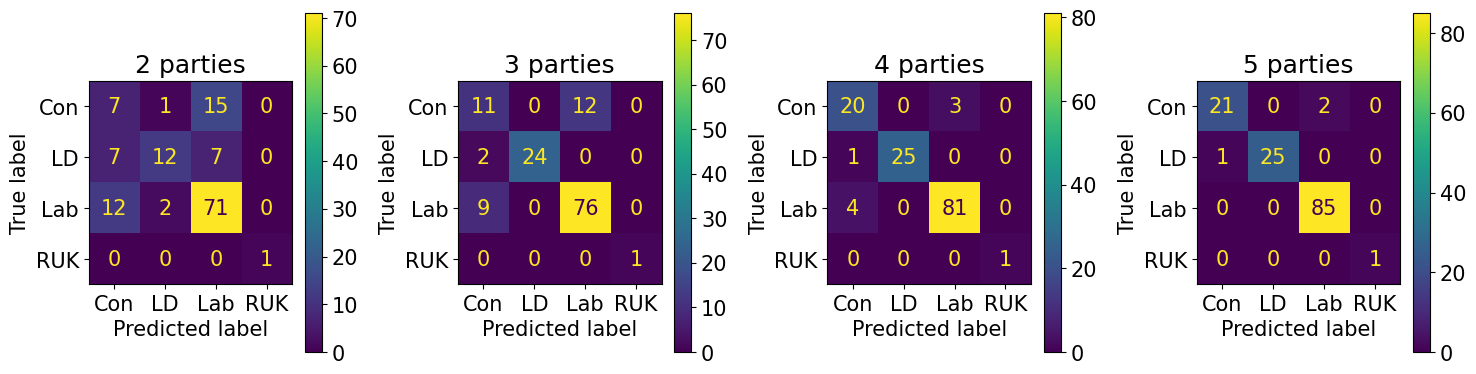

In [12]:
plt.rc('font', size=15)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 4))

shares_winner_new = shares_by_party[['First party', *['Green', 'RUK', 'LD', 'Con', 'Lab']]][~shares_by_party['Region name'].isin(['Scotland', 'Wales', 'Northern Ireland'])][~shares_by_party['First party'].isin(['Spk', 'Ind'])]
train_new, test_new = shares_winner_new.values[train_indexes], shares_winner_new.values[test_indexes]

Xs_train_1 = train_new[:,[1,2]]
y_train_1 = train_new[:,[0]].ravel()
Xs_test_1 = test_new[:,[1,2]]
y_test_1 = test_new[:,[0]].ravel()
knn.fit(Xs_train_1, y_train_1)
ConfusionMatrixDisplay.from_estimator(knn, Xs_test_1, y_test_1, ax=ax1)

Xs_train_2 = train_new[:,[1,2,3]]
y_train_2 = train_new[:,[0]].ravel()
Xs_test_2 = test_new[:,[1,2,3]]
y_test_2 = test_new[:,[0]].ravel()
knn.fit(Xs_train_2, y_train_2)
ConfusionMatrixDisplay.from_estimator(knn, Xs_test_2, y_test_2, ax=ax2)

Xs_train_3 = train_new[:,[1,2,3,4]]
y_train_3 = train_new[:,[0]].ravel()
Xs_test_3 = test_new[:,[1,2,3,4]]
y_test_3 = test_new[:,[0]].ravel()
knn.fit(Xs_train_3, y_train_3)
ConfusionMatrixDisplay.from_estimator(knn, Xs_test_3, y_test_3, ax=ax3)

Xs_train_4 = train_new[:,[1,2,3,4,5]]
y_train_4 = train_new[:,[0]].ravel()
Xs_test_4 = test_new[:,[1,2,3,4,5]]
y_test_4 = test_new[:,[0]].ravel()
knn.fit(Xs_train_4, y_train_4)
ConfusionMatrixDisplay.from_estimator(knn, Xs_test_4, y_test_4, ax=ax4)

ax1.set_title('2 parties')
ax2.set_title('3 parties')
ax3.set_title('4 parties')
ax4.set_title('5 parties')
plt.tight_layout()

Trying out various k in k-neighbors

Accuracy (n_neighbors=3): 0.67
Precision (n_neighbors=3): 0.71

Accuracy (n_neighbors=5): 0.67
Precision (n_neighbors=5): 0.67

Accuracy (n_neighbors=7): 0.69
Precision (n_neighbors=7): 0.69

Accuracy (n_neighbors=9): 0.72
Precision (n_neighbors=9): 0.48


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


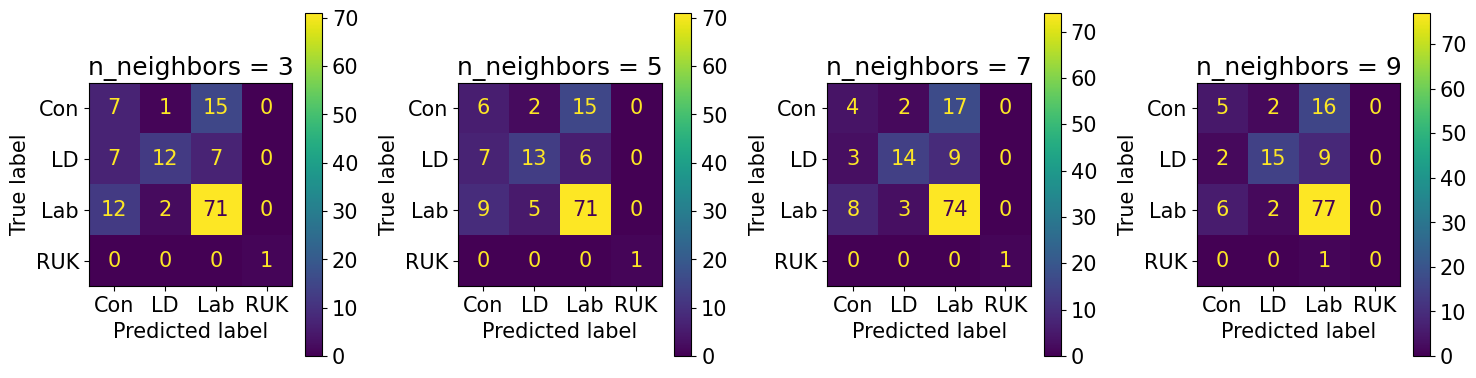

In [23]:
plt.rc('font', size=15)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 4))

knn1 = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
knn2 = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn3 = KNeighborsClassifier(n_neighbors=7, metric='euclidean')
knn4 = KNeighborsClassifier(n_neighbors=9, metric='euclidean')

knn1.fit(Xs_train, y_train)
knn2.fit(Xs_train, y_train)
knn3.fit(Xs_train, y_train)
knn4.fit(Xs_train, y_train)

ConfusionMatrixDisplay.from_estimator(knn1, Xs_test, y_test, ax=ax1)
ConfusionMatrixDisplay.from_estimator(knn2, Xs_test, y_test, ax=ax2)
ConfusionMatrixDisplay.from_estimator(knn3, Xs_test, y_test, ax=ax3)
ConfusionMatrixDisplay.from_estimator(knn4, Xs_test, y_test, ax=ax4)


ax1.set_title('n_neighbors = 3')
ax2.set_title('n_neighbors = 5')
ax3.set_title('n_neighbors = 7')
ax4.set_title('n_neighbors = 9')
plt.tight_layout()

print(f'Accuracy (n_neighbors=3): {accuracy_score(y_test, knn1.predict(Xs_test)):.2f}')
print(f'Precision (n_neighbors=3): {precision_score(y_test, knn1.predict(Xs_test), average="macro"):.2f}')
print()

print(f'Accuracy (n_neighbors=5): {accuracy_score(y_test, knn2.predict(Xs_test)):.2f}')
print(f'Precision (n_neighbors=5): {precision_score(y_test, knn2.predict(Xs_test), average="macro"):.2f}')
print()

print(f'Accuracy (n_neighbors=7): {accuracy_score(y_test, knn3.predict(Xs_test)):.2f}')
print(f'Precision (n_neighbors=7): {precision_score(y_test, knn3.predict(Xs_test), average="macro"):.2f}')
print()

print(f'Accuracy (n_neighbors=9): {accuracy_score(y_test, knn4.predict(Xs_test)):.2f}')
print(f'Precision (n_neighbors=9): {precision_score(y_test, knn4.predict(Xs_test), average="macro"):.2f}')